## Feature selection (from 15 different features) for prediction of percent body fat using backward elimination and forward selection methods

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Data overview

In [26]:
file_path = 'dane.txt'
df = pd.read_csv(file_path, delim_whitespace=True)
df

,Density,Pct.BF,Age,Weight,Height,Neck,Chest,Abdomen,Waist,Hip,Thigh,Knee,Ankle,Bicep,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,33.543307,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,32.677165,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,34.606299,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,34.015748,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,39.370079,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.0736,11.0,70,134.25,67.00,34.9,89.2,83.6,32.913386,88.8,49.6,34.8,21.5,25.6,25.7,18.5
246,1.0236,33.6,72,201.00,69.75,40.9,108.5,105.0,41.338583,104.5,59.6,40.8,23.2,35.2,28.6,20.1
247,1.0328,29.3,72,186.75,66.00,38.9,111.1,111.5,43.897638,101.7,60.3,37.3,21.5,31.3,27.2,18.0
248,1.0399,26.0,72,190.75,70.50,38.9,108.3,101.3,39.881890,97.8,56.0,41.6,22.7,30.5,29.4,19.8


C:\Users\oskar\AppData\Local\Temp\ipykernel_14128\288439230.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


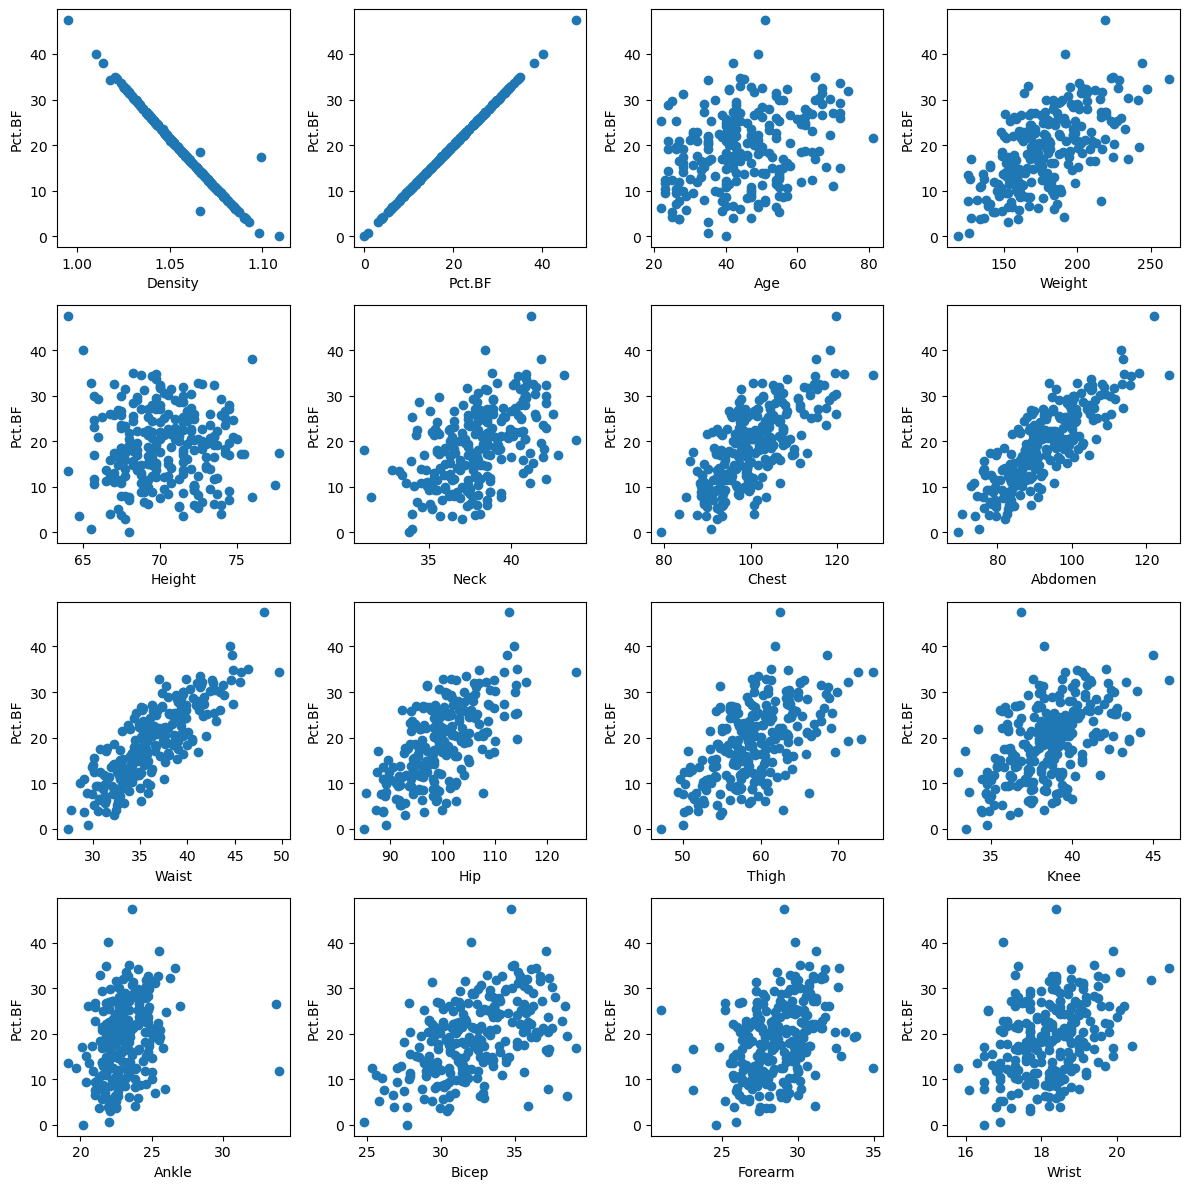

In [27]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
i = 0

for i, (name, X) in enumerate(df.items()):
    row = i // 4
    col = i % 4
    
    axs[row][col].scatter(X, df['Pct.BF'])
    axs[row][col].set_xlabel(name)
    axs[row][col].set_ylabel('Pct.BF')

fig.tight_layout()
fig.show()

In [28]:
y = df['Pct.BF']
X = df.drop('Pct.BF', axis=1)

## Implement elimination methods

In [29]:
def backward_elimination(df, y, significance_level=0.05):
    while True:
        X_with_intercept = add_constant(df)
        model = OLS(y, X_with_intercept).fit()
        max_p_value = model.pvalues[1:].max()
        if max_p_value > significance_level:
            max_index = model.pvalues[1:].argmax()
            removed_feature = df.columns[max_index]
            df = df.drop(removed_feature, axis=1)  
        else:
            break
    return df.columns

In [30]:
def forward_selection(df, y, significance_level=0.05):
    selected_features = []
    remaining_features = list(df.columns)
    
    while len(remaining_features) > 0:
        best_p_value = float('inf')
        best_feature = None
        
        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_with_intercept = add_constant(df[current_features])
            model = OLS(y, X_with_intercept).fit()
            p_value = model.pvalues[feature]
            
            if p_value < best_p_value:
                best_p_value = p_value
                best_feature = feature
        
        if best_p_value < significance_level:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
    
    return selected_features

## Both selection methods chose Density and Abdomen as the most important features in the prediction of body fat percentage, but if we want to use only one feature, we should discard Abdomen since it is in strong correlation with Abdomen

In [31]:
print(forward_selection(X, y, 0.05))

['Density', 'Abdomen']


In [32]:
print(backward_elimination(X, y, 0.05))

Index(['Density', 'Abdomen'], dtype='object')


In [33]:
df.corr()['Density']['Abdomen']

-0.8090420670424051

In [34]:
def calculate_model_stats(y_hat, y_true, X):
     X = np.insert(X, 0, 1, axis=1)
     residuals = y_true - y_hat
     residual_sum_of_squares = residuals.T @ residuals
     standard_variance = residual_sum_of_squares[0, 0] / (y_hat.shape[0] - X.shape[1])
     model_coefs_variances = standard_variance * np.linalg.inv(X.T @ X)
     stats = dict()
     for number in range(model_coefs_variances.shape[0]):
         stats['Standard error a' + str(number)] = np.sqrt(model_coefs_variances[number, number])
     stats['Standard error y'] = np.sqrt(standard_variance)
     return stats

## Create the model and plot predictions

In [35]:
D = df['Density']
B = df['Pct.BF']

In [36]:
D_train, D_test, B_train, B_test = train_test_split(D, B, test_size=0.2, random_state=42)

In [37]:
model = LinearRegression()
model.fit(D_train.values.reshape(-1, 1), B_train)

LinearRegression()

In [38]:
score = model.score(D_test.values.reshape(-1, 1), B_test)
print(f"R^2 score: {score}")

R^2 score: 0.9719197398956791


In [39]:
errors = calculate_model_stats(model.predict(D_train.to_numpy().reshape(-1, 1)), B_train.to_numpy().reshape(-1, 1), D_train.to_numpy().reshape(-1, 1))
B_error = errors['Standard error y']
print(errors)
print(f'a: {model.coef_}, b: {model.intercept_}')

{'Standard error a0': 38.282045950709964, 'Standard error a1': 36.26844989976589, 'Standard error y': 9.864292496982753}
a: [-430.64500052], b: 473.7901174256117


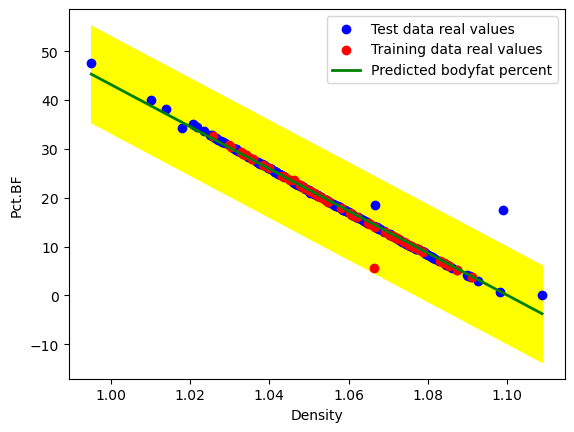

In [40]:
D_range = np.linspace(min(D), max(D), 100).reshape(-1, 1)
B_pred = model.predict(D_range)
plt.fill_between(D_range.reshape(-1), (B_pred - B_error).reshape(-1), (B_pred + B_error).reshape(-1), color='yellow')
plt.scatter(D_train, B_train, color='blue', label='Test data real values')
plt.scatter(D_test, B_test, color='red', label='Training data real values')
plt.plot(D_range, B_pred, color='green', linewidth=2, label='Predicted bodyfat percent')
plt.xlabel('Density')
plt.ylabel('Pct.BF')
plt.legend()